
# **<center><font color= lightseagreen > Natural Languange Processing </font></center>**




#<font color="lightseagreen">**Penjelasan Dataset**</font>
Dataset terdiri dari data train dan test yang berisi text tentang tweet dari orang-orang mengenai bencana alam. Dataset ini telah disediakan dari kaggle competition.

Sumber:  https://www.kaggle.com/competitions/nlp-getting-started/data

Dengan penjelasan isi kolom sebagai berikut:    
- **id**  
ID unik untuk setiap tweet.
- **keyword**  
Kata kunci (jika ada) dari tweet yang terkait dengan bencana.
- **location**  
Lokasi yang disebutkan dalam tweet (opsional, sering tidak terisi atau berisi informasi yang tidak relevan).
- **text**  
Teks tweet yang perlu dianalisis.
- **target**  
Label target, dengan nilai:
 - 1: Tweet ini relevan dengan bencana nyata.
 - 0: Tweet ini tidak relevan atau tidak menggambarkan bencana nyata.

#<font color="lightseagreen">**Data Preprocessing**</font>

In [ ]:
!pip install swifter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 31.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 16.9 MB/s eta 0:00:00
  Created wheel for swifter: filename=swifter-1.4.0-py3-none-any.whl size=16507 sha256=8132dcc6120f43918799e601ed6541898f39f77c6e75db0b77eddd8c7c0e76d5
  Stored in directory: /root/.cache/pip/wheels/e4/cf/51/0904952972ee2c7aa3709437065278dc534ec1b8d2ad41b443
Successfully built swifter


In [ ]:
import re
import string
import swifter
import pandas as pd
from IPython.display import display  # Import display for Jupyter
from textblob import TextBlob # Import TextBlob here
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from sklearn.model_selection import train_test_split # Import the train_test
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from collections import Counter
from wordcloud import WordCloud
import plotly.graph_objects as go
import seaborn as sns
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt


In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
train_data = pd.read_csv('https://raw.githubusercontent.com/shintachandra/DATA/main/train%20(1).csv')
test_data = pd.read_csv('https://raw.githubusercontent.com/shintachandra/DATA/main/test%20(1).csv')

In [ ]:
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
test_data.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
print(train_data.shape)
print('')
print(test_data.shape)

(7613, 5)

(3263, 4)


In [ ]:
# Definisi fungsi-fungsi untuk pembersihan teks
def clean_text(text):
    # Menghapus URL, karakter non-alfabet, dan mengubah teks menjadi huruf kecil
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    return text

def remove_URL(text):
    # Menghapus URL dari teks
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

def remove_html(text):
    # Menghapus tag HTML dari teks
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)

def remove_emoji(text):
    # Menghapus emoji dari teks
    emoji_pattern = re.compile("["  # Regex untuk berbagai jenis emoji
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # simbol & pictograms
                               u"\U0001F680-\U0001F6FF"  # simbol transportasi
                               u"\U0001F1E0-\U0001F1FF"  # bendera
                               u"\U00002702-\U000027B0"  # simbol tambahan
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_punct(text):
    # Menghapus tanda baca dari teks
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

def tokenize_and_remove_stopwords(text):
    # Tokenisasi teks dan menghapus stopwords bahasa Inggris
    words = text.split()
    stop_words_list = stopwords.words('english')
    filtered_words = [word for word in words if word not in stop_words_list]
    return ' '.join(filtered_words)

lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    # Lemmatization: Mengubah kata ke bentuk dasarnya
    return ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

def handle_elongated_words(text):
    # Menyederhanakan kata yang berulang (contoh: "sooo" menjadi "soo")
    return re.sub(r'(.)\1+', r'\1\1', text)

def remove_hash_prefix(text):
    # Menghapus tanda pagar (#) di awal kata
    return re.sub(r'#(\w+)', r'\1', text)

# Menggabungkan dataset train dan test menjadi satu
df = pd.concat([train_data, test_data])

# Membersihkan teks pada kolom 'text' di dataset
df['text'] = df['text'].apply(lambda x: remove_URL(x))         # Menghapus URL
df['text'] = df['text'].apply(lambda x: remove_html(x))        # Menghapus tag HTML
df['text'] = df['text'].apply(lambda x: remove_emoji(x))       # Menghapus emoji
df['text'] = df['text'].apply(lambda x: remove_punct(x))       # Menghapus tanda baca
df['text'] = df['text'].apply(lambda x: tokenize_and_remove_stopwords(x))  # Menghapus stopwords
df['text'] = df['text'].apply(lambda x: lemmatize_text(x))     # Lemmatization
df['text'] = df['text'].apply(lambda x: handle_elongated_words(x))  # Menyederhanakan kata berulang
df['text'] = df['text'].apply(lambda x: remove_hash_prefix(x))  # Menghapus tanda pagar
df['text'] = df['text'].apply(lambda x: clean_text(x))          # Membersihkan teks secara keseluruhan

# Menampilkan dataset yang telah dibersihkan
df

,id,keyword,location,text,target
0,1,NaN,NaN,our deeds reason earthquake may allah forgive u,1.0
1,4,NaN,NaN,forest fire near la ronge sask canada,1.0
2,5,NaN,NaN,all resident asked shelter place notified offi...,1.0
3,6,NaN,NaN,people receive wildfire evacuation order cali...,1.0
4,7,NaN,NaN,just got sent photo ruby alaska smoke wildfire...,1.0
...,...,...,...,...,...
3258,10861,NaN,NaN,earthquake safety los angeles safety fastener...,NaN
3259,10865,NaN,NaN,storm ri worse last hurricane my cityampothers...,NaN
3260,10868,NaN,NaN,green line derailment chicago,NaN
3261,10874,NaN,NaN,meg issue hazardous weather outlook hwo,NaN


In [ ]:
additional_stopwords = [
    'dont', 'im', 'new', 'just', 'make', 'like', 'youre', 'really', 'want',
    'said', 'good', 'stop', 'today', 'year', 'pm', 'rt', 'stor', 'gnews', 'first',
    'one', 'two', 'work', 'last', 'via', 'service', 'come', 'may', 'lol', 'see',
    'w', 'never', 'read', 'u', 'another', 'please', 'mh', 'still',
    'gan', 'game', '091', '1m', 'black', 'family', 'home', 'hope', 'boy', 'would',
    'even', 'going', 'man', 'could', 'way', 'many', 'full', 'take', 'back',
    'great', 'severe', 'right', 'best', 'photo', 'woman', 'legionnaires', 'shit',
    'let', 'get', 'got', 'going' 'say', 'think', 'youtube', 'need', 'still', 'say',
    'asked', 'us', 'look', 'go', 'video', 'watch', 'cant', 'one', 'know', 'love'
]

def tokenize_and_remove_stopwords_custom(text):
    # Tokenisasi teks dan menghapus stopwords bahasa Inggris serta stopwords manual
    words = text.split()
    stop_words_list = stopwords.words('english') + additional_stopwords
    filtered_words = [word for word in words if word not in stop_words_list]
    return ' '.join(filtered_words)

df['text'] = df['text'].apply(lambda x: tokenize_and_remove_stopwords_custom(x))

df

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake allah forgive,1.0
1,4,NaN,NaN,forest fire near la ronge sask canada,1.0
2,5,NaN,NaN,resident shelter place notified officer evacua...,1.0
3,6,NaN,NaN,people receive wildfire evacuation order calif...,1.0
4,7,NaN,NaN,sent ruby alaska smoke wildfire pours school,1.0
...,...,...,...,...,...
3258,10861,NaN,NaN,earthquake safety los angeles safety fasteners...,NaN
3259,10865,NaN,NaN,storm ri worse hurricane cityampothers hardest...,NaN
3260,10868,NaN,NaN,green line derailment chicago,NaN
3261,10874,NaN,NaN,meg issue hazardous weather outlook hwo,NaN


In [ ]:
#df['text'] = df['text'].swifter.apply(lambda x: correct_spellings(x))

In [ ]:
# Create a DataFrame with the preprocessed text
#preprocessed_data = pd.DataFrame({
#    'text': df['text'] # Preprocessed text
#})

# Save the DataFrame to a CSV file
#preprocessed_data.to_csv('preprocessed_data.csv', index=False)

# Download the CSV file
# Import the necessary module to interact with Google Colab
#from google.colab import files
#files.download('preprocessed_data.csv')

# EDA

Link voyant: https://voyant-tools.org/?corpus=389304309c008e5a838ae964f2e62779

<Axes: xlabel='target', ylabel='count'>

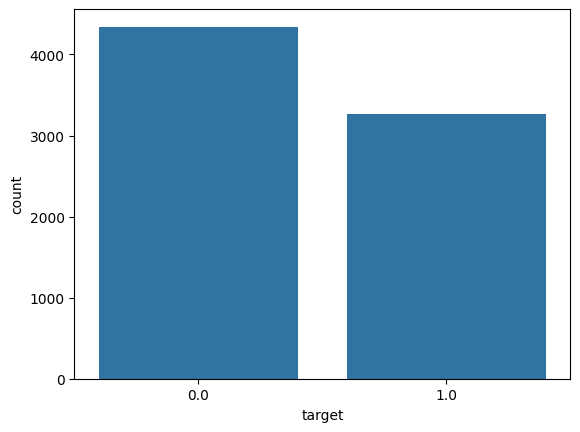

In [ ]:
x = df['target'].value_counts()
sns.barplot(x=x.index,y=x)

In [ ]:
# 1. WORD-COUNT
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
print("Word Count\n\nDisaster")

print(df[df['target'] == 1]['word_count'].mean())  # Disaster
print("\nNon-disaster")
print(df[df['target'] == 0]['word_count'].mean())  # Non-disaster

# 2. CHARACTER-COUNT
df['char_count'] = df['text'].apply(lambda x: len(str(x)))
print("\nCharacter-Count\n\nDisaster")
print(df[df['target'] == 1]['char_count'].mean())  # Disaster
print("\nNon-disaster")
print(df[df['target'] == 0]['char_count'].mean())  # Non-disaster

# 3. UNIQUE WORD-COUNT
df['unique_word_count'] = df['text'].apply(lambda x: len(set(str(x).split())))
print("\nUnique Word-Count\n\nDisaster")
print(df[df['target'] == 1]['unique_word_count'].mean())  # Disaster
print("\nNon-disaster")
print(df[df['target'] == 0]['unique_word_count'].mean())  # Non-disaster


Word Count

Disaster
8.692754509324365

Non-disaster
7.659603869184708

Character-Count

Disaster
63.33506572913482

Non-disaster
54.275218793182866

Unique Word-Count

Disaster
8.45765820849893

Non-disaster
7.492860432980193


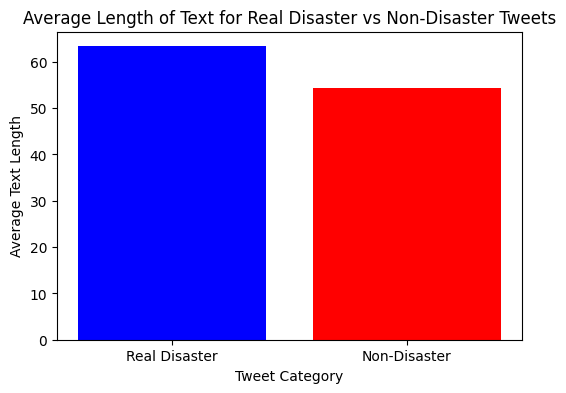

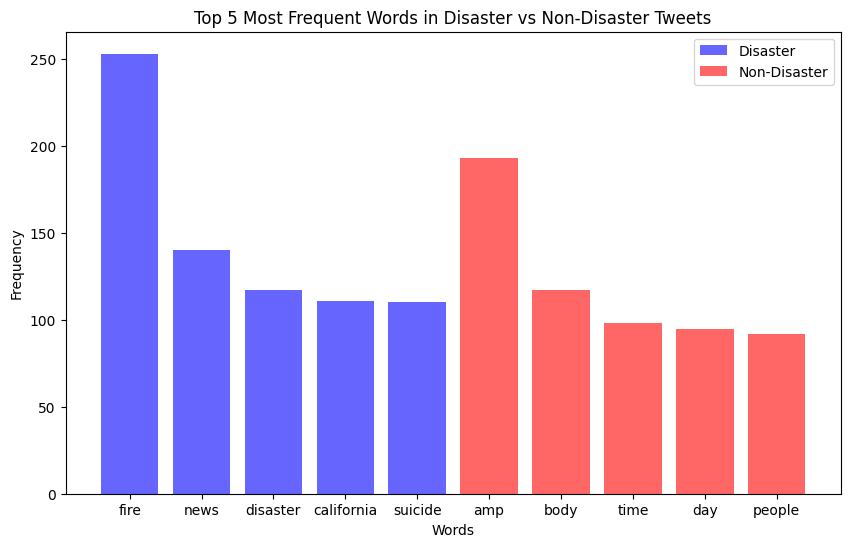

In [ ]:
# Menghitung panjang teks
df['text_length'] = df['text'].apply(len)

# Memisahkan antara Real disaster tweets dan Non-disaster tweets
disaster_tweets = df[df['target'] == 1]
non_disaster_tweets = df[df['target'] == 0]

# Menghitung rata - rata panjang teks
avg_text_length_disaster = disaster_tweets['text_length'].mean()
avg_text_length_non_disaster = non_disaster_tweets['text_length'].mean()

# Plot perbedaan mean kedua jenis tweets
plt.figure(figsize=(6, 4))
plt.bar(['Real Disaster', 'Non-Disaster'], [avg_text_length_disaster, avg_text_length_non_disaster], color=['blue', 'red'])
plt.title('Average Length of Text for Real Disaster vs Non-Disaster Tweets')
plt.xlabel('Tweet Category')
plt.ylabel('Average Text Length')
plt.show()

# Menghitung jumlah kata di kedua jenis tweets
disaster_words = ' '.join(disaster_tweets['text'])
disaster_word_counts = Counter(disaster_words.split())

non_disaster_words = ' '.join(non_disaster_tweets['text'])
non_disaster_word_counts = Counter(non_disaster_words.split())

top_5_disaster_words = disaster_word_counts.most_common(5)
top_5_disaster_words_words, top_5_disaster_words_counts = zip(*top_5_disaster_words)

# Mendapatkan top 5 kata terbanyak untuk kedua jenis tweets
top_5_non_disaster_words = non_disaster_word_counts.most_common(5)
top_5_non_disaster_words_words, top_5_non_disaster_words_counts = zip(*top_5_non_disaster_words)

# Plot top 5 kata terbanyak untuk kedua jenis tweets
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(top_5_disaster_words_words, top_5_disaster_words_counts, label='Disaster', alpha=0.6, color='blue')
ax.bar(top_5_non_disaster_words_words, top_5_non_disaster_words_counts, label='Non-Disaster', alpha=0.6, color='red')

ax.set_xlabel('Words')
ax.set_ylabel('Frequency')
ax.set_title('Top 5 Most Frequent Words in Disaster vs Non-Disaster Tweets')
ax.legend()

plt.show()


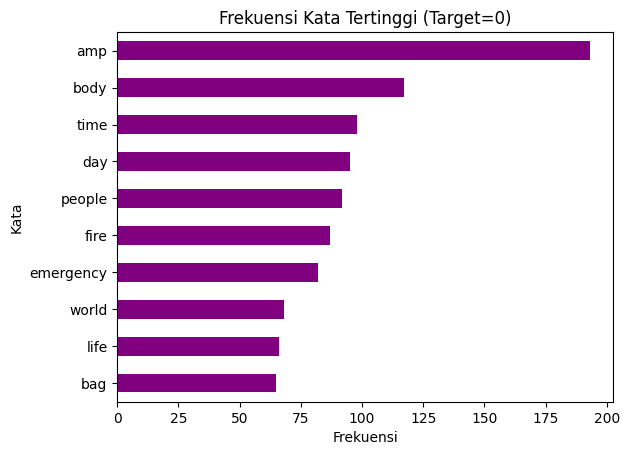

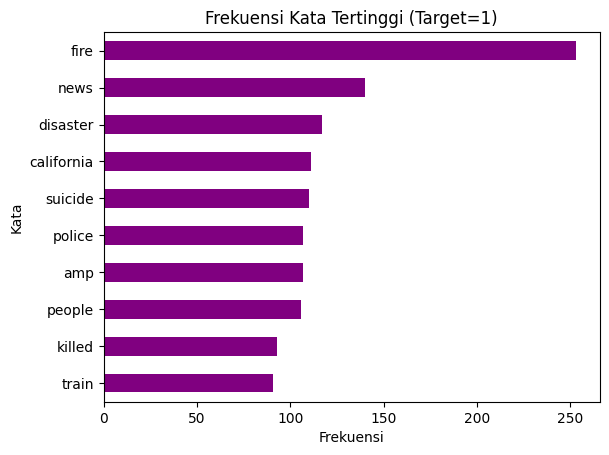

In [ ]:
from collections import Counter

# Get top 10 most common words for each category
for label in [0, 1]:
    words = df[df['target'] == label]['text'].str.split().sum()
    word_freq = Counter(words).most_common(10)
    df_word_freq = pd.DataFrame(word_freq, columns=['Kata', 'Frekuensi'])

    # Plot horizontal bar chart
    df_word_freq.plot(kind='barh', x='Kata', y='Frekuensi', color='purple', legend=False)
    plt.title(f'Frekuensi Kata Tertinggi (Target={label})')
    plt.xlabel('Frekuensi')
    plt.ylabel('Kata')
    plt.gca().invert_yaxis()
    plt.show()


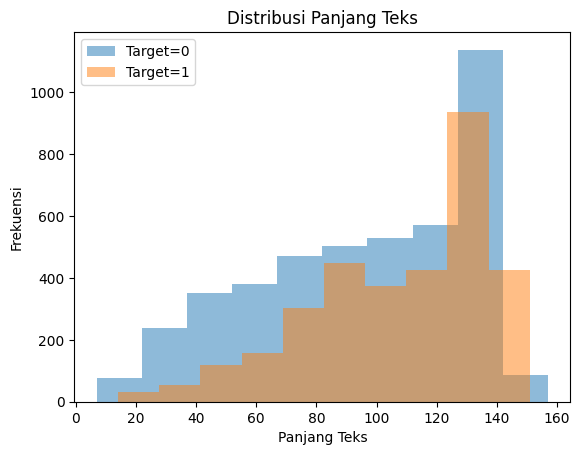

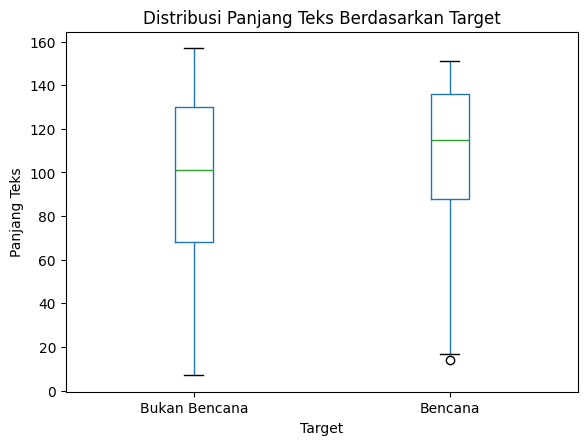

In [ ]:
# Add text length column from raw text
train_data['text_length'] = train_data['text'].str.len()

# Histogram
for label in [0, 1]:
    train_data[train_data['target'] == label]['text_length'].plot(kind='hist', alpha=0.5, label=f'Target={label}')
plt.title('Distribusi Panjang Teks')
plt.xlabel('Panjang Teks')
plt.ylabel('Frekuensi')
plt.legend()
plt.show()

# Boxplot
train_data.boxplot(column='text_length', by='target', grid=False)
plt.title('Distribusi Panjang Teks Berdasarkan Target')
plt.suptitle('')
plt.xlabel('Target')
plt.ylabel('Panjang Teks')
plt.xticks([1, 2], ['Bukan Bencana', 'Bencana'])
plt.show()


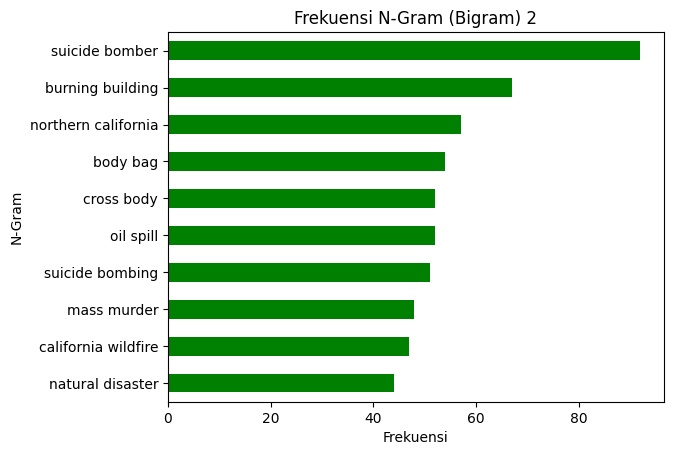

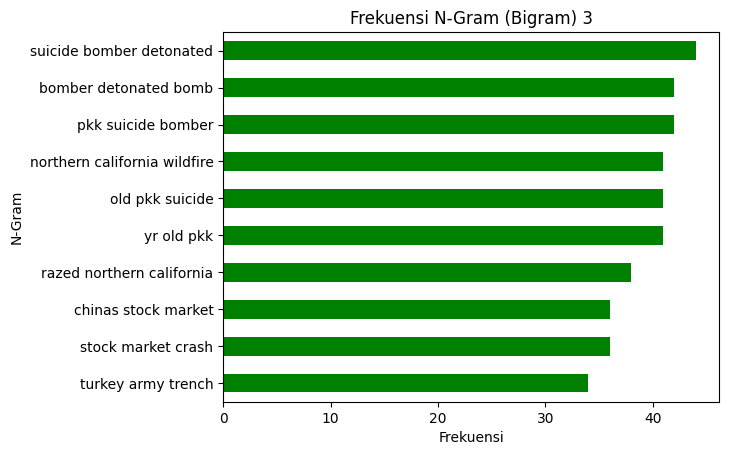

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# N-grams from final_text 2
ngram_vectorizer = CountVectorizer(ngram_range=(2, 2), max_features=10)
ngrams = ngram_vectorizer.fit_transform(df['text'])

# Most common n-grams
ngram_df_2 = pd.DataFrame(ngrams.toarray(), columns=ngram_vectorizer.get_feature_names_out())
top_ngrams_2 = ngram_df_2.sum().sort_values(ascending=False).head(10)

# Horizontal bar chart
top_ngrams_2.plot(kind='barh', color='green')
plt.title('Frekuensi N-Gram (Bigram) 2')
plt.xlabel('Frekuensi')
plt.ylabel('N-Gram')
plt.gca().invert_yaxis()
plt.show()

# N-grams from final_text 3
ngram_vectorizer = CountVectorizer(ngram_range=(3, 3), max_features=10)
ngrams = ngram_vectorizer.fit_transform(df['text'])

# Most common n-grams
ngram_df_3 = pd.DataFrame(ngrams.toarray(), columns=ngram_vectorizer.get_feature_names_out())
top_ngrams_3 = ngram_df_3.sum().sort_values(ascending=False).head(10)

# Horizontal bar chart
top_ngrams_3.plot(kind='barh', color='green')
plt.title('Frekuensi N-Gram (Bigram) 3')
plt.xlabel('Frekuensi')
plt.ylabel('N-Gram')
plt.gca().invert_yaxis()
plt.show()


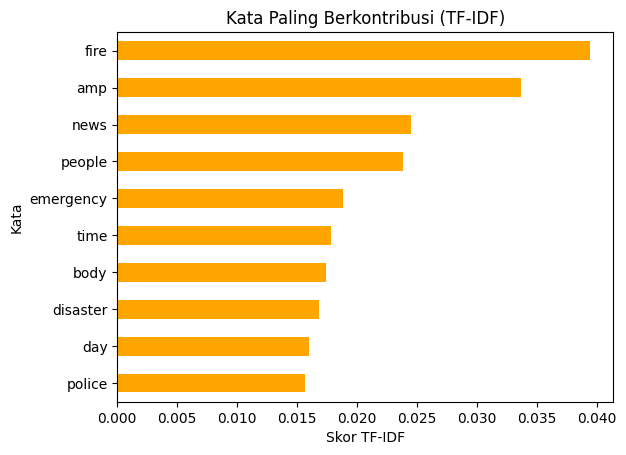

In [ ]:
# TF-IDF from text
tfidf_vectorizer = TfidfVectorizer(max_features=10)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['text'])

# Top TF-IDF words
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
top_tfidf = tfidf_df.mean().sort_values(ascending=False).head(10)

# Horizontal bar chart
top_tfidf.plot(kind='barh', color='orange')
plt.title('Kata Paling Berkontribusi (TF-IDF)')
plt.xlabel('Skor TF-IDF')
plt.ylabel('Kata')
plt.gca().invert_yaxis()
plt.show()


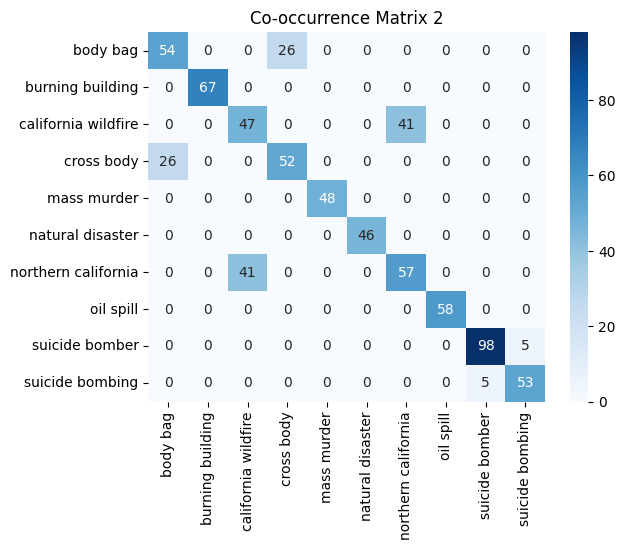

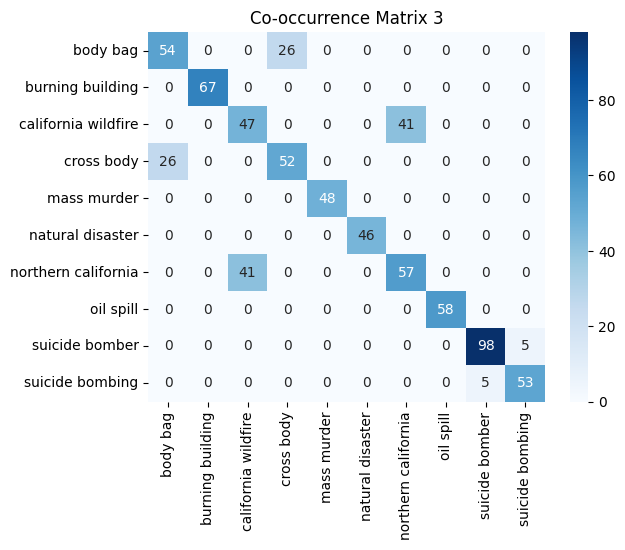

In [ ]:
# Co-occurrence matrix from final_text
co_matrix = (ngram_df_2.T @ ngram_df_2)
sns.heatmap(co_matrix, cmap='Blues', annot=True, fmt='d')
plt.title('Co-occurrence Matrix 2')
plt.show()

co_matrix = (ngram_df_2.T @ ngram_df_2)
sns.heatmap(co_matrix, cmap='Blues', annot=True, fmt='d')
plt.title('Co-occurrence Matrix 3')
plt.show()


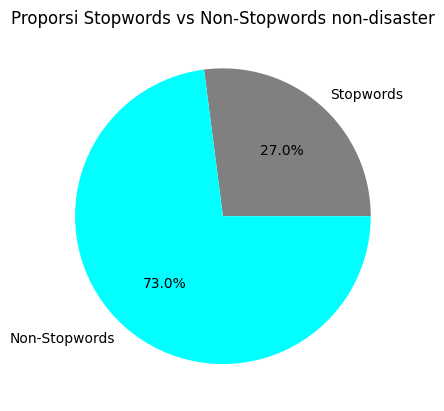

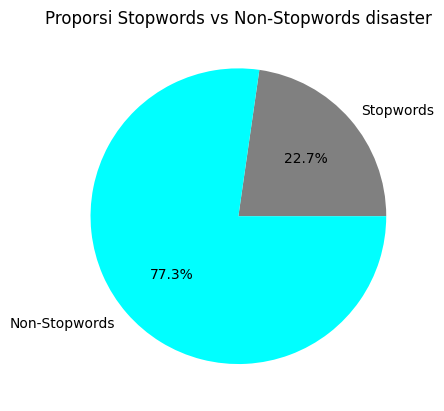

In [ ]:
# Stopword analysis from final_text
stop_words = set(stopwords.words('english'))
train_data['stopword_count'] = train_data['text'].apply(lambda x: sum(1 for word in x.split() if word in stop_words))
train_data['non_stopword_count'] = train_data['text'].apply(lambda x: sum(1 for word in x.split() if word not in stop_words))

# Pie chart
train_data[train_data['target']==0][['stopword_count', 'non_stopword_count']].sum().plot(kind='pie', autopct='%1.1f%%', labels=['Stopwords', 'Non-Stopwords'], colors=['gray', 'cyan'])
plt.title('Proporsi Stopwords vs Non-Stopwords non-disaster')
plt.ylabel('')
plt.show()

# Pie chart
train_data[train_data['target']==1][['stopword_count', 'non_stopword_count']].sum().plot(kind='pie', autopct='%1.1f%%', labels=['Stopwords', 'Non-Stopwords'], colors=['gray', 'cyan'])
plt.title('Proporsi Stopwords vs Non-Stopwords disaster')
plt.ylabel('')
plt.show()


In [ ]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

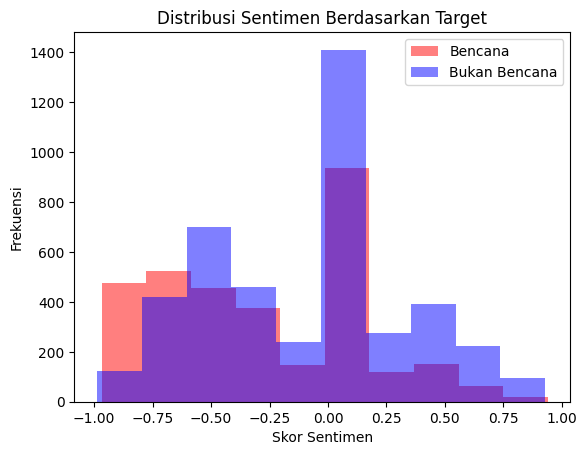

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer

# Sentiment analysis from final_text
sia = SentimentIntensityAnalyzer()
df['sentiment'] = df['text'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Histogram
df[df['target'] == 1]['sentiment'].plot(kind='hist', alpha=0.5, label='Bencana', color='red')
df[df['target'] == 0]['sentiment'].plot(kind='hist', alpha=0.5, label='Bukan Bencana', color='blue')
plt.title('Distribusi Sentimen Berdasarkan Target')
plt.xlabel('Skor Sentimen')
plt.ylabel('Frekuensi')
plt.legend()
plt.show()


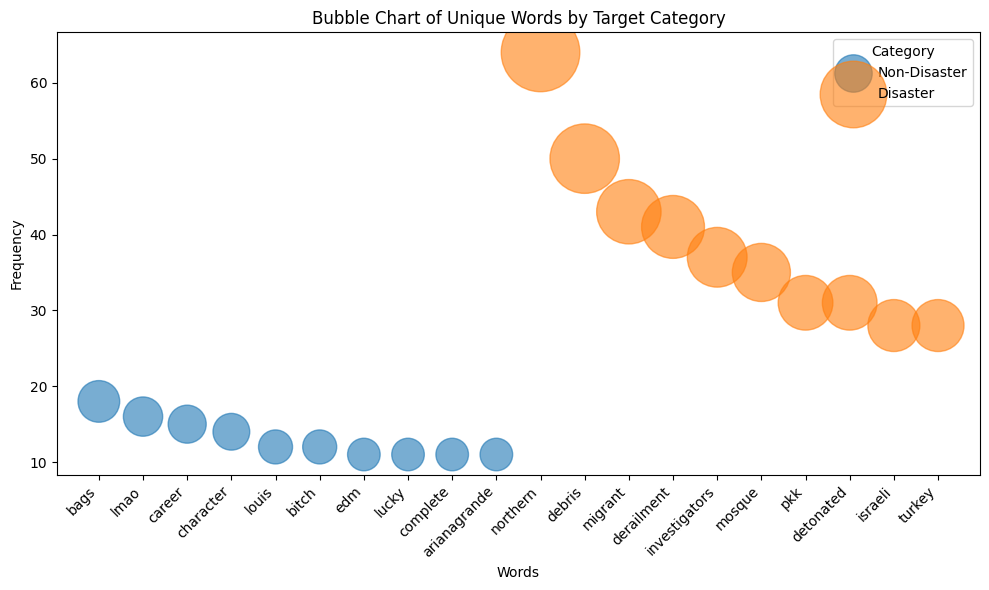

In [ ]:
# Extract unique words from final_text for each category
unique_words = {label: set(df[df['target'] == label]['text'].str.split().sum()) for label in [0, 1]}
unique_0 = unique_words[0] - unique_words[1]
unique_1 = unique_words[1] - unique_words[0]

# Count the frequencies of unique words for each target
freq_0 = Counter([word for word in df[df['target'] == 0]['text'].str.split().sum() if word in unique_0])
freq_1 = Counter([word for word in df[df['target'] == 1]['text'].str.split().sum() if word in unique_1])

# Select top 10 unique words for each category
top_unique_0 = freq_0.most_common(10)
top_unique_1 = freq_1.most_common(10)

# Create bubble chart data for target = 0
df_0 = pd.DataFrame(top_unique_0, columns=['Word', 'Frequency'])
df_0['Target'] = 'Non-Disaster'

# Create bubble chart data for target = 1
df_1 = pd.DataFrame(top_unique_1, columns=['Word', 'Frequency'])
df_1['Target'] = 'Disaster'

# Combine both into a single DataFrame
bubble_data = pd.concat([df_0, df_1])

# Create the bubble chart
plt.figure(figsize=(10, 6))

# Create scatter for each target
for target in bubble_data['Target'].unique():
    subset = bubble_data[bubble_data['Target'] == target]
    plt.scatter(
        x=subset['Word'],
        y=subset['Frequency'],
        s=subset['Frequency'] * 50,  # Size of bubble is proportional to frequency
        alpha=0.6,
        label=target
    )

plt.title("Bubble Chart of Unique Words by Target Category")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.legend(title="Category")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


#<font color="lightseagreen">**Pre-Modeling**</font>

## Pemisahan Train dan Test Awal

In [ ]:
# Misahin train dan test berdasarkan ukuran data
train_data = df.iloc[:7613].reset_index(drop=True)  # Baris pertama hingga 7613
test_data = df.iloc[7613:].reset_index(drop=True)  # Baris setelah 7613 hingga akhir

test_data = test_data.drop(columns=['target'])

# Periksa hasilnya
print("Train dataset shape:", train_data.shape)
print("Test dataset shape:", test_data.shape)

Train dataset shape: (7613, 10)
Test dataset shape: (3263, 9)


## Splitting Data

In [ ]:
X_train = train_data['text']
y_train = train_data['target']
X_test = test_data['text']

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state = 42)

#<font color="lightseagreen">**Modeling**</font>

## TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

# 1. Fungsi TF-IDF
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(data)
    return tfidf_matrix, tfidf_vectorizer

# 2. Mengubah data teks ke dalam bentuk TF-IDF
X_train_tfidf, tfidf_vectorizer = tfidf(X_train)  # Data pelatihan
X_val_tfidf = tfidf_vectorizer.transform(X_val)  # Data validasi

# 3. Inisialisasi dan melatih model Naive Bayes
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_tfidf, y_train)  # Latih model dengan data training TF-IDF

# 4. Melakukan prediksi pada data validasi (atau data uji jika Anda punya X_test_tfidf)
y_predict = nb_tfidf.predict(X_val_tfidf)  # Uji pada data validasi
y_prob = nb_tfidf.predict_proba(X_val_tfidf)[:, 1]  # Probabilitas prediksi

# 5. Menampilkan hasil evaluasi
print("TF - IDF - Classification Report:\n", classification_report(y_val, y_predict))  # Laporan evaluasi
print("TF - IDF - Confusion Matrix:\n", confusion_matrix(y_val, y_predict))  # Confusion Matrix

TF - IDF - Classification Report:
               precision    recall  f1-score   support

         0.0       0.79      0.88      0.83       874
         1.0       0.80      0.68      0.74       649

    accuracy                           0.79      1523
   macro avg       0.79      0.78      0.78      1523
weighted avg       0.79      0.79      0.79      1523

TF - IDF - Confusion Matrix:
 [[765 109]
 [207 442]]


Interpretasi  

**Classification Report**
- Precision: Proporsi prediksi positif yang benar dibandingkan dengan semua prediksi positif.  
 Untuk kelas 0 (tidak relevan): Precision sebesar 79% berarti dari semua tweet yang diprediksi tidak relevan dengan bencana, 79% benar-benar tidak relevan.
Untuk kelas 1 (relevan): Precision sebesar 80% berarti dari semua tweet yang diprediksi relevan dengan bencana, 80% benar-benar relevan.
- Recall: Proporsi prediksi positif yang benar dibandingkan dengan semua kasus positif sebenarnya.  
 Untuk kelas 0: Recall sebesar 88% berarti model berhasil mendeteksi 88% tweet yang benar-benar tidak relevan.
Untuk kelas 1: Recall sebesar 68% berarti model hanya berhasil mendeteksi 68% tweet yang benar-benar relevan.
- F1-Score: Rata-rata harmonis dari precision dan recall.
 F1-Score untuk kelas 0 adalah 83%, menunjukkan keseimbangan yang baik antara precision dan recall untuk kelas tidak relevan.
F1-Score untuk kelas 1 adalah 74%, menunjukkan bahwa model masih kesulitan menyeimbangkan precision dan recall untuk kelas relevan.
- Akurasi: Model memiliki akurasi keseluruhan sebesar 79%, artinya 79% prediksi benar untuk data validasi.


**Confusion Matrix**  

- True Negatives (TN): 765 tweet diprediksi sebagai tidak relevan dan memang benar tidak relevan.
- False Positives (FP): 109 tweet diprediksi sebagai relevan, tetapi sebenarnya tidak relevan.
- False Negatives (FN): 207 tweet diprediksi sebagai tidak relevan, tetapi sebenarnya relevan.
- True Positives (TP): 442 tweet diprediksi sebagai relevan dan memang benar relevan.



Kesimpulan  
**Imbalance Kinerja pada Kelas Relevan**  
Recall untuk kelas 1 lebih rendah (68%) dibandingkan recall kelas 0 (88%). Hal ini menunjukkan bahwa model kesulitan mendeteksi tweet yang relevan dengan bencana. Masalah ini bisa terjadi karena jumlah tweet relevan (kelas 1) lebih sedikit dibandingkan tweet tidak relevan (kelas 0) dalam data asli, sehingga model lebih fokus pada kelas mayoritas.

**Confusion Matrix**  
Jumlah False Negatives (207) cukup tinggi, artinya banyak tweet relevan yang tidak terdeteksi. Ini bisa berpengaruh pada aplikasi di dunia nyata, terutama jika tujuan utama adalah mendeteksi tweet relevan.

## KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Membuat dan melatih model KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_tfidf, y_train)

# Memprediksi hasil pada data validasi
y_pred = knn.predict(X_val_tfidf)

# Evaluasi model
print("KNN - Classification Report:\n", classification_report(y_val, y_pred))
print("KNN - Confusion Matrix:\n", confusion_matrix(y_val, y_pred))


KNN - Classification Report:
               precision    recall  f1-score   support

         0.0       0.70      0.95      0.81       874
         1.0       0.87      0.46      0.60       649

    accuracy                           0.74      1523
   macro avg       0.79      0.71      0.71      1523
weighted avg       0.78      0.74      0.72      1523

KNN - Confusion Matrix:
 [[830  44]
 [349 300]]


Interpretasi

**Classification Report**  
- Precision: Persentase prediksi positif yang benar.

 Untuk kelas 0 (tidak relevan): 70%, artinya dari semua tweet yang diprediksi sebagai tidak relevan, 70% benar-benar tidak relevan.
Untuk kelas 1 (relevan): 87%, artinya dari semua tweet yang diprediksi relevan, 87% benar-benar relevan.
- Recall: Persentase prediksi yang benar dibandingkan dengan jumlah sebenarnya.

 Untuk kelas 0: 95%, artinya model berhasil mendeteksi 95% dari semua tweet yang tidak relevan.
Untuk kelas 1: 46%, artinya model hanya berhasil mendeteksi 46% dari semua tweet yang relevan.
- F1-Score: Rata-rata harmonis antara precision dan recall.

 F1-Score untuk kelas 0 adalah 81%, menunjukkan model lebih baik dalam mendeteksi tweet yang tidak relevan.
F1-Score untuk kelas 1 adalah 60%, menunjukkan kinerja yang lebih buruk dalam mendeteksi tweet yang relevan.
- Akurasi: 74%, artinya model berhasil membuat prediksi yang benar untuk 74% data validasi.

**Confusion Matrix**
- True Negatives (TN): 830 tweet diprediksi sebagai tidak relevan, dan benar tidak relevan.
- False Positives (FP): 44 tweet diprediksi sebagai relevan, tetapi sebenarnya tidak relevan.
- False Negatives (FN): 349 tweet diprediksi sebagai tidak relevan, tetapi sebenarnya relevan.
- True Positives (TP): 300 tweet diprediksi sebagai relevan, dan benar relevan.

Kesimpulan  
**Ketidakseimbangan Kinerja Antar Kelas**  
Model KNN sangat baik dalam mendeteksi tweet tidak relevan (kelas 0) dengan recall 95%, tetapi buruk dalam mendeteksi tweet relevan (kelas 1) dengan recall hanya 46%.
Banyak tweet relevan yang terklasifikasi sebagai tidak relevan (349 False Negatives), yang berarti model kehilangan banyak informasi penting pada aplikasi di dunia nyata.

**Bias terhadap Kelas Mayoritas**  
Model KNN cenderung bias terhadap kelas mayoritas (tidak relevan) karena distribusi kelas yang tidak seimbang.

**Kinerja Precision Tinggi untuk Kelas Relevan**  
Meskipun recall rendah untuk kelas 1, precision-nya tinggi (87%). Artinya, jika model memprediksi tweet relevan, kemungkinan besar prediksi tersebut benar.

## Regresi Logistik

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Membuat dan melatih model Regresi Logistik
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_tfidf, y_train)

# Memprediksi hasil pada data validasi
y_pred_logreg = logreg.predict(X_val_tfidf)

# Evaluasi model
print("Logistic Regression - Classification Report:\n", classification_report(y_val, y_pred_logreg))
print("Logistic Regression - Confusion Matrix:\n", confusion_matrix(y_val, y_pred_logreg))


Logistic Regression - Classification Report:
               precision    recall  f1-score   support

         0.0       0.78      0.89      0.83       874
         1.0       0.82      0.67      0.74       649

    accuracy                           0.80      1523
   macro avg       0.80      0.78      0.78      1523
weighted avg       0.80      0.80      0.79      1523

Logistic Regression - Confusion Matrix:
 [[776  98]
 [214 435]]


Interpretasi  
**Classification Report**  
- Precision: Persentase prediksi positif yang benar.  
 Untuk kelas 0 (tidak relevan): 78%, artinya dari semua tweet yang diprediksi tidak relevan, 78% benar-benar tidak relevan.
Untuk kelas 1 (relevan): 82%, artinya dari semua tweet yang diprediksi relevan, 82% benar-benar relevan.
- Recall: Proporsi prediksi benar dibandingkan dengan jumlah sebenarnya.  
 Untuk kelas 0: 89%, artinya model berhasil mendeteksi 89% dari semua tweet yang tidak relevan.
Untuk kelas 1: 67%, artinya model hanya mendeteksi 67% dari semua tweet yang relevan.
- F1-Score: Rata-rata harmonis antara precision dan recall.  
 F1-Score untuk kelas 0 adalah 83%, menunjukkan kinerja yang sangat baik untuk kelas tidak relevan.
F1-Score untuk kelas 1 adalah 74%, menunjukkan bahwa model cukup baik, tetapi masih ada ruang untuk perbaikan pada deteksi tweet relevan.
- Akurasi: 80%, artinya model membuat prediksi yang benar untuk 80% data validasi.

**Confusion Matrix**
- True Negatives (TN): 776 tweet diprediksi tidak relevan dan benar-benar tidak relevan.
- False Positives (FP): 98 tweet diprediksi relevan, tetapi sebenarnya tidak relevan.
- False Negatives (FN): 214 tweet diprediksi tidak relevan, tetapi sebenarnya relevan.
- True Positives (TP): 435 tweet diprediksi relevan dan benar-benar relevan.

Kesimpulan  
**Keseimbangan Precision dan Recall**  
Logistic Regression memiliki precision yang cukup baik untuk kedua kelas (kelas 0: 78%, kelas 1: 82%). Ini menunjukkan model cukup akurat dalam membedakan tweet relevan dan tidak relevan.
Recall untuk kelas 1 masih relatif rendah (67%), yang berarti model kehilangan sekitar 33% dari tweet relevan.

**Kesalahan pada Tweet Relevan**  
False Negatives (FN): Sebanyak 214 tweet relevan diklasifikasikan sebagai tidak relevan. Kesalahan ini penting untuk diperhatikan jika aplikasi di dunia nyata lebih memprioritaskan deteksi tweet relevan.

**Kinerja Keseluruhan**  
Dengan akurasi 80%, Logistic Regression memberikan hasil yang lebih baik dibandingkan KNN (74%) dan hampir setara dengan TF-IDF + Naive Bayes (79%).
Logistic Regression memberikan keseimbangan yang cukup baik antara precision dan recall dibandingkan dengan KNN, yang memiliki masalah pada recall kelas 1.

## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Membuat dan melatih model Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_tfidf, y_train)

# Memprediksi hasil pada data validasi
y_pred_dt = dt.predict(X_val_tfidf)

# Evaluasi model
print("Decision Tree - Classification Report:\n", classification_report(y_val, y_pred_dt))
print("Decision Tree - Confusion Matrix:\n", confusion_matrix(y_val, y_pred_dt))


Decision Tree - Classification Report:
               precision    recall  f1-score   support

         0.0       0.76      0.76      0.76       874
         1.0       0.67      0.68      0.68       649

    accuracy                           0.72      1523
   macro avg       0.72      0.72      0.72      1523
weighted avg       0.72      0.72      0.72      1523

Decision Tree - Confusion Matrix:
 [[661 213]
 [208 441]]


Interpretasi  
**Classification Report**
- Precision: Persentase prediksi positif yang benar.    
 Untuk kelas 0 (tidak relevan): 76%, artinya dari semua tweet yang diprediksi sebagai tidak relevan, 76% benar-benar tidak relevan.  
Untuk kelas 1 (relevan): 67%, artinya dari semua tweet yang diprediksi relevan, 67% benar-benar relevan.
- Recall: Proporsi prediksi benar dibandingkan dengan jumlah sebenarnya.  
 Untuk kelas 0: 76%, artinya model berhasil mendeteksi 76% dari semua tweet yang tidak relevan.  
Untuk kelas 1: 68%, artinya model berhasil mendeteksi 68% dari semua tweet yang relevan.
- F1-Score: Rata-rata harmonis antara precision dan recall.  
 Untuk kelas 0: 76%, menunjukkan model cukup baik dalam mendeteksi tweet tidak relevan.  
Untuk kelas 1: 68%, menunjukkan model memiliki kinerja yang lebih lemah dalam mendeteksi tweet relevan.
- Akurasi: 72%, artinya model membuat prediksi yang benar untuk 72% data validasi.

**Confusion Matrix**  
- True Negatives (TN): 661 tweet diprediksi tidak relevan dan benar-benar tidak relevan.
- False Positives (FP): 213 tweet diprediksi relevan, tetapi sebenarnya tidak relevan.
- False Negatives (FN): 208 tweet diprediksi tidak relevan, tetapi sebenarnya relevan.
- True Positives (TP): 441 tweet diprediksi relevan dan benar-benar relevan.


Kesimpulan  
**Keseimbangan Precision dan Recall**  
Precision untuk kelas 0 lebih tinggi (76%) dibandingkan kelas 1 (67%), menunjukkan model lebih akurat dalam memprediksi tweet tidak relevan.
Recall untuk kedua kelas relatif seimbang (76% untuk kelas 0 dan 68% untuk kelas 1).

**Kesalahan Prediksi (FP dan FN)**  
Sebanyak 213 False Positives menunjukkan model sering memprediksi tweet relevan padahal tidak relevan.
Sebanyak 208 False Negatives menunjukkan model kehilangan cukup banyak tweet relevan, yang dapat berdampak buruk jika aplikasi di dunia nyata memprioritaskan deteksi tweet relevan.

**Kinerja Keseluruhan**  
Akurasi keseluruhan (72%) lebih rendah dibandingkan Logistic Regression (80%) dan Naive Bayes (79%).
Kinerja pada kelas relevan lebih rendah dibandingkan Logistic Regression (F1-Score kelas 1: 68% vs. 74% pada Logistic Regression).

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Membuat dan melatih model Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_tfidf, y_train)

# Memprediksi hasil pada data validasi
y_pred_rf = rf.predict(X_val_tfidf)

# Evaluasi model
print("Random Forest - Classification Report:\n", classification_report(y_val, y_pred_rf))
print("Random Forest - Confusion Matrix:\n", confusion_matrix(y_val, y_pred_rf))

Random Forest - Classification Report:
               precision    recall  f1-score   support

         0.0       0.78      0.84      0.81       874
         1.0       0.76      0.69      0.72       649

    accuracy                           0.77      1523
   macro avg       0.77      0.76      0.77      1523
weighted avg       0.77      0.77      0.77      1523

Random Forest - Confusion Matrix:
 [[735 139]
 [204 445]]


Interpretasi  

**Classification Report**
- Precision: Persentase prediksi positif yang benar.
 Untuk kelas 0 (tidak relevan): 78%, artinya dari semua tweet yang diprediksi tidak relevan, 78% benar-benar tidak relevan.
Untuk kelas 1 (relevan): 76%, artinya dari semua tweet yang diprediksi relevan, 76% benar-benar relevan.
- Recall: Proporsi prediksi benar dibandingkan dengan jumlah sebenarnya.
 Untuk kelas 0: 84%, artinya model berhasil mendeteksi 84% dari semua tweet yang tidak relevan.
Untuk kelas 1: 69%, artinya model berhasil mendeteksi 69% dari semua tweet yang relevan.
- F1-Score: Rata-rata harmonis antara precision dan recall.
 Untuk kelas 0: 81%, menunjukkan kinerja yang baik dalam mendeteksi tweet tidak relevan.
Untuk kelas 1: 72%, menunjukkan model cukup baik dalam mendeteksi tweet relevan, meskipun masih ada ruang untuk perbaikan.
- Akurasi: 77%, artinya model membuat prediksi yang benar untuk 77% data validasi.

**Confusion Matrix**
- True Negatives (TN): 735 tweet diprediksi tidak relevan dan benar-benar tidak relevan.
- False Positives (FP): 139 tweet diprediksi relevan, tetapi sebenarnya tidak relevan.
- False Negatives (FN): 204 tweet diprediksi tidak relevan, tetapi sebenarnya relevan.
- True Positives (TP): 445 tweet diprediksi relevan dan benar-benar relevan.


Kesimpulan  
**Keseimbangan Precision dan Recall**  
Precision untuk kedua kelas cukup baik (78% untuk kelas 0, 76% untuk kelas 1), menunjukkan model cukup akurat dalam memprediksi tweet relevan maupun tidak relevan.
Recall untuk kelas 1 (69%) lebih rendah dibandingkan kelas 0 (84%), yang menunjukkan bahwa model kehilangan sekitar 31% tweet relevan.

**Kesalahan Prediksi (FP dan FN)**  
Sebanyak 139 False Positives menunjukkan bahwa beberapa tweet yang tidak relevan diprediksi sebagai relevan.
Sebanyak 204 False Negatives menunjukkan bahwa model kehilangan cukup banyak tweet relevan.

**Kinerja Keseluruhan**  
Akurasi model (77%) lebih rendah dibandingkan Logistic Regression (80%) dan TF-IDF + Naive Bayes (79%).
Kinerja pada kelas relevan (1) sedikit lebih baik dibandingkan Decision Tree (F1-Score kelas 1: 72% vs. 68% pada Decision Tree).

## SVM

In [ ]:
from sklearn.svm import SVC

# Membuat dan melatih model Support Vector Machine
svm = SVC(kernel='linear', random_state=42)
svm.fit(X_train_tfidf, y_train)

# Memprediksi hasil pada data validasi
y_pred_svm = svm.predict(X_val_tfidf)

# Evaluasi model
print("SVM - Classification Report:\n", classification_report(y_val, y_pred_svm))
print("SVM - Confusion Matrix:\n", confusion_matrix(y_val, y_pred_svm))


SVM - Classification Report:
               precision    recall  f1-score   support

         0.0       0.80      0.84      0.82       874
         1.0       0.77      0.71      0.74       649

    accuracy                           0.79      1523
   macro avg       0.78      0.78      0.78      1523
weighted avg       0.78      0.79      0.78      1523

SVM - Confusion Matrix:
 [[734 140]
 [187 462]]


Interpretasi  
**Classification Report**
- Precision: Persentase prediksi positif yang benar.  
 Kelas 0 (tidak relevan): 80%, artinya dari semua tweet yang diprediksi tidak relevan, 80% benar-benar tidak relevan.
Kelas 1 (relevan): 77%, artinya dari semua tweet yang diprediksi relevan, 77% benar-benar relevan.
- Recall: Proporsi prediksi benar dibandingkan dengan jumlah sebenarnya.  
 Kelas 0: 84%, artinya model berhasil mendeteksi 84% dari semua tweet yang tidak relevan.
Kelas 1: 71%, artinya model berhasil mendeteksi 71% dari semua tweet yang relevan.
- F1-Score: Rata-rata harmonis antara precision dan recall.  
 Kelas 0: 82%, menunjukkan kinerja yang baik dalam mendeteksi tweet yang tidak relevan.
Kelas 1: 74%, menunjukkan model cukup baik dalam mendeteksi tweet yang relevan.
- Akurasi: 79%, artinya model membuat prediksi yang benar untuk 79% data validasi.

**Confusion Matrix**
- True Negatives (TN): 734 tweet diprediksi tidak relevan dan benar-benar tidak relevan.
- False Positives (FP): 140 tweet diprediksi relevan, tetapi sebenarnya tidak relevan.
- False Negatives (FN): 187 tweet diprediksi tidak relevan, tetapi sebenarnya relevan.
- True Positives (TP): 462 tweet diprediksi relevan dan benar-benar relevan.


Kesimpulan  
**Keseimbangan Precision dan Recall**  
Precision untuk kelas 0 (80%) dan kelas 1 (77%) cukup seimbang, menunjukkan model relatif baik dalam membedakan tweet relevan dan tidak relevan.
Recall untuk kelas 1 (71%) lebih rendah dibandingkan kelas 0 (84%), menunjukkan bahwa model kehilangan sekitar 29% tweet yang relevan.

**Kesalahan Prediksi (FP dan FN)**  
140 False Positives menunjukkan bahwa ada beberapa tweet yang sebenarnya tidak relevan tetapi diprediksi relevan.
187 False Negatives menunjukkan bahwa model melewatkan beberapa tweet relevan.

**Kinerja Keseluruhan**  
Model SVM mencapai akurasi 79%, hampir sebanding dengan Logistic Regression (80%) dan Naive Bayes dengan TF-IDF (79%).
F1-Score untuk kelas relevan (74%) lebih baik dibandingkan Decision Tree (68%) dan KNN (60%).

### HASIL  
<p align="justify"> Dari enam model yang diuji, **Logistic Regression** dan **SVM** menunjukkan performa terbaik dengan akurasi masing-masing 80% dan 79%, serta keseimbangan yang baik antara precision dan recall. **Naive Bayes** juga memberikan hasil yang kompetitif (akurasi 79%) dengan keunggulan proses pelatihan yang lebih cepat. **Random Forest** memiliki akurasi 77% dan lebih tahan terhadap overfitting dibandingkan Decision Tree, tetapi sedikit lebih lambat. **Decision Tree** dan **KNN** memiliki performa terendah dengan akurasi masing-masing 72% dan 74%, terutama kesulitan mendeteksi tweet relevan (kelas 1). Secara keseluruhan, Logistic Regression dan SVM direkomendasikan untuk prediksi karena kinerja yang stabil dan efisien, sementara Random Forest dapat dipertimbangkan untuk menangkap hubungan non-linear yang lebih kompleks.

#<font color="lightseagreen">**Evaluasi**</font>

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd
from tabulate import tabulate

# Menghitung classification report dengan output_dict=True
reports = {
    "TF-IDF": classification_report(y_val, y_predict, output_dict=True),
    "KNN": classification_report(y_val, y_pred, output_dict=True),
    "Logistic Regression": classification_report(y_val, y_pred_logreg, output_dict=True),
    "Decision Tree": classification_report(y_val, y_pred_dt, output_dict=True),
    "Random Forest": classification_report(y_val, y_pred_rf, output_dict=True),
    "SVM": classification_report(y_val, y_pred_svm, output_dict=True)
}

# Menyusun data ke dalam tabel
rows = []
for model_name, metrics in reports.items():
    f1_class_0 = metrics["0.0"]["f1-score"]
    f1_class_1 = metrics["1.0"]["f1-score"]
    average_f1 = (f1_class_0 + f1_class_1) / 2  # Rata-rata F1 score

    rows.append({
        "Model": model_name,
        "F1_Score_0": f1_class_0,
        "F1_Score_1": f1_class_1,
        "Average_F1_Score": average_f1  # Menambahkan kolom rata-rata F1 score
    })

# Membuat DataFrame
df = pd.DataFrame(rows)

# Menampilkan tabel dengan kotak-kotak
print(tabulate(df, headers='keys', tablefmt='grid'))

+----+---------------------+--------------+--------------+--------------------+
|    | Model               |   F1_Score_0 |   F1_Score_1 |   Average_F1_Score |
+====+=====================+==============+==============+====================+
|  0 | TF-IDF              |     0.828819 |     0.736667 |           0.782743 |
+----+---------------------+--------------+--------------+--------------------+
|  1 | KNN                 |     0.808573 |     0.60423  |           0.706401 |
+----+---------------------+--------------+--------------+--------------------+
|  2 | Logistic Regression |     0.832618 |     0.736041 |           0.784329 |
+----+---------------------+--------------+--------------+--------------------+
|  3 | Decision Tree       |     0.758462 |     0.676899 |           0.717681 |
+----+---------------------+--------------+--------------+--------------------+
|  4 | Random Forest       |     0.810811 |     0.721817 |           0.766314 |
+----+---------------------+------------

Evaluasi model dilakukan dengan melihat nilai rata-rata dari **F1 Score** masing-masing model untuk mendapatkan model terbaik untuk memprediksi nilai target pada data uji.

Pemilihan F1 Score dikarenakan kemampuannya untuk memberikan gambaran yang lebih baik tentang performa model, terutama dalam kasus ketidakseimbangan kelas. F1 Score menggabungkan **Precision** dan **Recall**, sehingga membantu menyeimbangkan trade-off antara keduanya dan memberikan perhatian lebih pada kelas minoritas yang lebih penting untuk deteksi yang akurat.

Terlihat bahwa Model **Logistic Regression** memiliki nilai rata-rata F1 Score paling tinggi di antara model yang lain, yaitu 0,7989. Diikuti dengan model **TF-IDF** sebesar 0.7916, model **SVM** sebesar 0.7872, model **Random Forest** sebesar 0.7701, model **KNN** sebesar 0.7541, dan terakir model **Decision Tree** sebesar 0.7204.

Sehingga, model **Model Logistic Regression** dipilih sebagai model terbaik untuk memprediksi nilai target pada data uji.

## Cross validation

In [ ]:
from sklearn.model_selection import cross_val_score

#Melakukan cross-validation pada model Regresi Logistik
cv_scores = cross_val_score(logreg, X_train_tfidf, y_train, cv=5, scoring='accuracy')  # cv=5 berarti 5-fold cross-validation

#Menampilkan hasil cross-validation
print("Cross-validation Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

Cross-validation Scores: [0.79064039 0.80541872 0.80213465 0.76929392 0.78325123]
Mean CV Accuracy: 0.7901477832512315


* **Konsistensi Model**: Model menunjukkan konsistensi yang baik pada setiap fold dengan akurasi yang tidak berbeda jauh antar fold (sekitar 78-80%). Ini menunjukkan bahwa model tidak overfitting pada data pelatihan dan cukup stabil.
* **Rata-rata Akurasi**: Rata-rata akurasi 79.33% menunjukkan bahwa model memiliki performa yang cukup baik pada data pelatihan.

## Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

# Mendefinisikan grid parameter untuk model Regresi Logistik
param_grid = {
     'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
     'solver': ['liblinear', 'lbfgs'],  # Algoritma solver
     'penalty': ['l2']  # Jenis regularisasi
}

# Menggunakan GridSearchCV untuk mencari parameter terbaik
grid_search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Melatih model dengan pencarian grid
grid_search.fit(X_train_tfidf, y_train)

# Menampilkan hasil hyperparameter tuning
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

# Menggunakan parameter terbaik untuk memprediksi hasil pada data validasi
best_logreg = grid_search.best_estimator_
y_pred_best_logreg = best_logreg.predict(X_val_tfidf)

# Evaluasi model dengan parameter terbaik
print("Logistic Regression - Best Model - Classification Report:\n", classification_report(y_val, y_pred_best_logreg))
print("Logistic Regression - Best Model - Confusion Matrix:\n", confusion_matrix(y_val, y_pred_best_logreg))

Best Hyperparameters: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
Best Cross-Validation Score: 0.7901477832512315
Logistic Regression - Best Model - Classification Report:
               precision    recall  f1-score   support

         0.0       0.78      0.89      0.83       874
         1.0       0.82      0.67      0.74       649

    accuracy                           0.80      1523
   macro avg       0.80      0.78      0.78      1523
weighted avg       0.80      0.80      0.79      1523

Logistic Regression - Best Model - Confusion Matrix:
 [[776  98]
 [214 435]]


Model Logistic Regression dengan hyperparameter terbaik (C = 1, penalty = 'l2', solver = 'lbfgs') menunjukkan kinerja yang solid dengan akurasi 81% dan F1-Score 0.80.

#<font color="lightseagreen">**Menyiapkan Submission File**</font>

In [ ]:
submission_kel5 = test_data['id']

X_test_tfidf = tfidf_vectorizer.transform(X_test)  # Data validasi
y_pred_hyperparameter_tuning = best_logreg.predict(X_test_tfidf)
submission_kel5  = pd.DataFrame({'id': submission_kel5, 'target': y_pred_hyperparameter_tuning})

In [ ]:
sample_submission = pd.read_csv('/content/sample_submission.csv')

In [ ]:
# Cek apakah ID dan Target pada file submission dan test_data sesuai
if sample_submission['id'].equals(submission_kel5['id']):
   print("ID pada file submission dan test_data sesuai!")
else:
   print("ID pada file submission dan test_data tidak sesuai!")

if sample_submission['target'].equals(submission_kel5['target']):
    print("Target pada file submission dan test_data sesuai!")
else:
    print("Target pada file submission dan test_data tidak sesuai!")

ID pada file submission dan test_data sesuai!
Target pada file submission dan test_data tidak sesuai!


In [ ]:
# Melihat tipe data
print(sample_submission.dtypes)
print(submission_kel5.dtypes)

id        int64
target    int64
dtype: object
id          int64
target    float64
dtype: object


In [ ]:
# Mengganti tipe data target menjadi integer pada submission kel5
submission_kel5['target'] = submission_kel5['target'].astype(int)

In [ ]:
# Mengisi kolom target pada DataFrame sample_submission berdasarkan pemetaan nilai id dari DataFrame lain (submission_kel5)
sample_submission['target'] = sample_submission['id'].map(
    dict(zip(submission_kel5['id'], submission_kel5['target']))
)

sample_submission.loc[sample_submission['target'] == 1, 'target'] = 1

In [ ]:
print(submission_kel5.head())
print(submission_kel5.shape)

   id  target
0   0       1
1   2       1
2   3       1
3   9       1
4  11       1
(3263, 2)


In [ ]:
print(submission_kel5.shape)

(3263, 2)


In [ ]:
# Mendownload file menjadi csv
sample_submission.to_csv('Submission.csv', index=False)